In [1]:
# import required libraries
from pynq import Overlay
from pynq import MMIO
import time

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load PL configuration file (design_1.bit and design_1.hwh are required in the same directory)
base = Overlay("./design_1.bit")

In [3]:
# access handlers
mmio_data = MMIO(base_addr = base.ip_dict['axi_bram_ctrl_1']['phys_addr'],
            length = 0x4000,
            debug = False)
mmio_ctrl = MMIO(base_addr = base.ip_dict['axi_bram_ctrl_0']['phys_addr'],
            length = 0x2000,
            debug = False)

In [4]:
# a helper method to access a SPI device
def kick_spi(repetition,      # the number of repetitions to access the SPI device
             repeat_margin,   # cycles between repeat access
             din,             # data for the SPI device (left justified)
             clk_half_period, # cycles for the half of SCLK
             cs_delay,        # delay before asserting CS
             data_delay,      # delay before output MSB
             miso_width,      # data bit-width of MISO (from device)
             mosi_width,      # data bit-width of MOSI (to device)
             cpha,            # CPHA(0: first edge, 1: second edge)
             cpol,            # CPOL(0: SCLK default is '0', 1: SCLK default is '1')
             mode=0,          # trigger mode(0: use internal trigger, 1: use external trigger)
            ):
    mmio_ctrl.write(1*4, (repetition << 16) + (repeat_margin & 0x0000FFFF))
    mmio_ctrl.write(2*4, din)
    mmio_ctrl.write(3*4, clk_half_period)
    mmio_ctrl.write(4*4, cs_delay)
    mmio_ctrl.write(5*4, data_delay)
    mmio_ctrl.write(6*4, miso_width)
    mmio_ctrl.write(7*4, mosi_width)
    mmio_ctrl.write(8*4, ((cpha&0x1)<<1) + (cpol&0x1))
    kick = 1 if mode == 0 else 5
    mmio_ctrl.write(0*4, kick)
    while(mmio_ctrl.read(0*4) & 0x80000000 != 0): # wait for SPI access
        pass

In [5]:
# a helper method to read/write ADT7310 registers
def read_adt7310_reg(reg, miso_width = 8, repetition = 1, mode=0):
    command = (((0x40 + ((reg&0x7)<<3))&0xFF) << 24)
    kick_spi(repetition, 0, command, 15, 5, 5, miso_width, 8, 1, 1, mode)
    v = mmio_data.read(0, 4)
    return v

In [6]:
# try to read ADT7310 registers
print(hex(read_adt7310_reg(3))) # ID: 0x1C*
print(hex(read_adt7310_reg(4, 16))) # T_CRIT = 0x14980
print(hex(read_adt7310_reg(5))) # T_HYST = 0x105
print(hex(read_adt7310_reg(6, 16))) # T_HIGH = 0x12000
print(hex(read_adt7310_reg(7, 16))) # T_LOW = 0x10500

print(hex(read_adt7310_reg(3)&0x0FF)) # ID: 0xC*
print(hex(read_adt7310_reg(4, 16)&0x0FF)) # T_CRIT = 0x4980
print(hex(read_adt7310_reg(5)&0x0FF)) # T_HYST = 0x05
print(hex(read_adt7310_reg(6, 16)&0x0FFFF)) # T_HIGH = 0x2000
print(hex(read_adt7310_reg(7, 16)&0x0FFFF)) # T_LOW = 0x0500

0x1c3
0x14980
0x105
0x12000
0x10500
0xc3
0x80
0x5
0x2000
0x500


In [7]:
# a helper method to read temprature via ADT7310
def hex2tmp(v):
    if (v>>15 == 1):
        v = -1 * (v & 0x7FFF)
    else:
        v = v & 0x7FFF
    return v / 128
    
def read_adt7310_tmp(repetition=1):
    v = read_adt7310_reg(2, 16, repetition) & 0x0FFFF
    print(hex(v))
    return hex2tmp(v)

In [8]:
# try to read temprature at once
print(read_adt7310_tmp())

0x990
19.125


In [9]:
# try to read temprature at 4times. (5-th memory data should be the default BRAM value)
read_adt7310_tmp(4)
for i in range(5):
    print(hex2tmp(mmio_data.read(i*4, 4)))

0x990
19.125
19.125
19.125
19.125
0.0


<IPython.core.display.Javascript object>


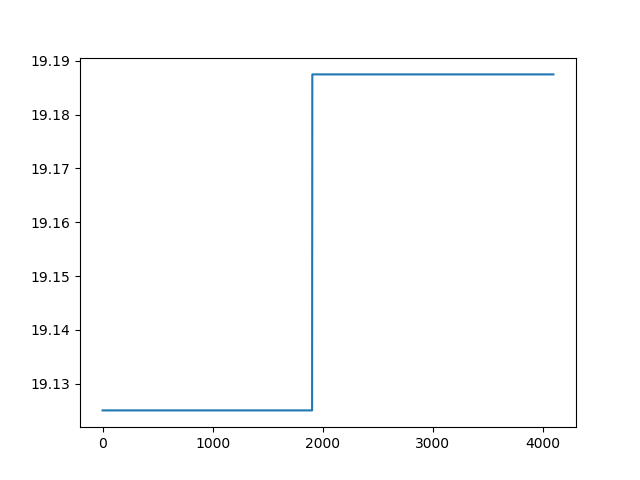

0x990
elapsed: 0.8235142230987549
0x990
elapsed: 0.8198549747467041
0x998
elapsed: 0.7729449272155762
0x990
elapsed: 0.7708497047424316
0x990
elapsed: 0.7711441516876221
0x998
elapsed: 0.8791329860687256
0x998
elapsed: 0.7710301876068115
0x998
elapsed: 0.7704274654388428
0x998
elapsed: 0.7754068374633789
0x990
elapsed: 0.7832555770874023


In [10]:
# try to read temprature repeatedly in PL, and plot the results 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(10):
    start = time.time()
    ax.clear()
    read_adt7310_tmp(repetition=4096)
    list = []
    for i in range(4096):
        list.append(hex2tmp(mmio_data.read(i*4, 4)))
    ax.plot(list)
    fig.canvas.draw()
    end = time.time()
    print("elapsed:", end-start)

<IPython.core.display.Javascript object>


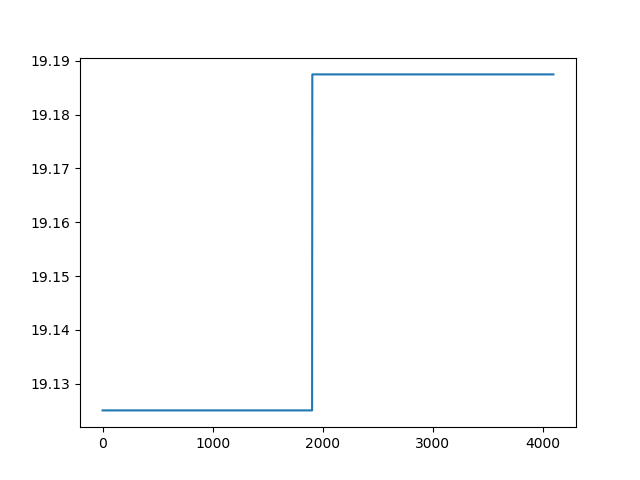

elapsed(read and plot data): 0.7537164688110352
elapsed(read and plot data): 0.7626028060913086
elapsed(read and plot data): 0.7364697456359863
elapsed(read and plot data): 0.7624995708465576
elapsed(read and plot data): 0.7718775272369385
elapsed(read and plot data): 0.7287859916687012
elapsed(read and plot data): 0.727393627166748
elapsed(read and plot data): 0.7322680950164795
elapsed(read and plot data): 0.7496626377105713
elapsed(read and plot data): 0.7389063835144043


In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(10):
    start = time.time()
    ax.clear()
    list = []
    for i in range(4096):
        list.append(hex2tmp(mmio_data.read(i*4, 4)))
    ax.plot(list)
    fig.canvas.draw()
    end = time.time()
    print("elapsed(read and plot data):", end-start)

<IPython.core.display.Javascript object>


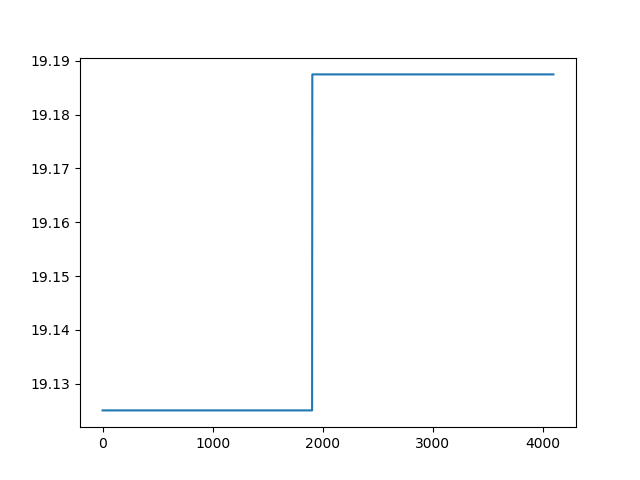

elapsed(read data) 0.10889267921447754
elapsed(read data) 0.10879158973693848
elapsed(read data) 0.10865449905395508
elapsed(read data) 0.10838007926940918
elapsed(read data) 0.10837674140930176
elapsed(read data) 0.10875558853149414
elapsed(read data) 0.1090841293334961
elapsed(read data) 0.1086130142211914
elapsed(read data) 0.10892081260681152
elapsed(read data) 0.10862112045288086


In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(10):
    ax.clear()
    list = []
    start = time.time()
    for i in range(4096):
        list.append(hex2tmp(mmio_data.read(i*4, 4)))
    end = time.time()
    print("elapsed(read data)", end-start)
    ax.plot(list)
    fig.canvas.draw()

In [13]:
# try to emit SPI access with external-tirgger (ex. BTN0)
print(hex(read_adt7310_reg(3, mode=1))) # ID: 0x1C*
print(hex(read_adt7310_reg(4, 16, mode=1))) # T_CRIT = 0x14980
print(hex(read_adt7310_reg(5, mode=1))) # T_HYST = 0x105
print(hex(read_adt7310_reg(6, 16, mode=1))) # T_HIGH = 0x12000
print(hex(read_adt7310_reg(7, 16, mode=1))) # T_LOW = 0x10500

0x1c3
0x14980
0x105
0x12000
0x10500
